In [1]:
### continue from old messy SK notebook

In [1]:
######################
##### Imports ######
######################

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from sunpy.time import TimeRange

import pandas as pd
import xarray as xr

from scipy.signal import stft, istft
import scipy.stats as st

%matplotlib notebook

/home/ofionnad/realta/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
######################
##### Functions ######
######################

def sb_to_f(sbs, obs_mode):
    nyq_dict = {3:1, 5:2, 7:3}
    nyq_zone = nyq_dict[obs_mode]
    clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
    clock = clock_dict[obs_mode]
    nu = (nyq_zone-1. + sbs/512.) * (clock/2.)
    return nu * u.MHz

def plot_spectrum_plt(data, freqs):
    plt.imshow(data.T, aspect='auto', origin='lower',
           vmin=np.percentile(data.T, 5), 
           vmax=np.percentile(data.T, 95),
           extent=[0, data.shape[1], min(freqs[30:150]).value, max(freqs[30:150]).value])

def plot_stft_map(stft_i, i):
	"""
	i - particular index corresponding to individual subband stft
	stft_i - value returned from scipy.signal.stft()
			 should be a 3d tuple if passing more than 1 subband to stft()
	"""
	f, ax = plt.subplots(2)
	ax[0].pcolormesh(stft_i[1], stft_i[0], np.abs(stft_i[2][:,i,:]), shading='auto', 
					 vmin=np.percentile(np.abs(sft_i[2][:,i,:]), 2), 
					 vmax=np.percentile(np.abs(sft_i[2][:,i,:]), 98))

def spectral_kurtosis(stft_arr, size=2):
	frac_top = np.mean((np.abs(stft_arr)**4), axis=size)
	frac_bottom = np.mean((np.abs(stft_arr)**2), axis=size)**2
	return (frac_top / frac_bottom) - 2.

def sk_threshold(ci, sft_times):
    sd = np.sqrt(4. /sft_times) #variance is 4/length of time dimension
    return st.norm.interval(ci, scale=sd)[1] #returns coordsinates that contain ci% of data in line with a gaussian centred at 0 with std=sd

######################

In [3]:
######################
#### Reading data ####
######################

fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 320)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.min)
"""
fname = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:47:00_19563125244140'
sbs = np.arange(76, 319)
obs_mode = 3
trange = TimeRange("2020-10-13T17:47:00", 10.*u.minute)
"""

xlabel = "Time"
ylabel = "Frequency (MHz)"
title = "Jupiter - Stokes I"

data = np.memmap(fname, np.float32, mode="c")
data = data.reshape(-1, sbs.shape[0])
data = np.flip(data, axis=1)

times = pd.timedelta_range(start="0 millisecond", periods=data.shape[0], freq='81.92U')
freqs = sb_to_f(sbs, obs_mode)

######################

#You can use xarray or just numpy, depending on the datatype and size/shape
dx = xr.DataArray(data, coords=[np.arange(len(times)),freqs], dims=["Time", "Frequency"])


In [4]:
# Normalise data (removes frequency dependence)
norms = dx.quantile(0.1, dim="Time")
dxn = dx/norms

In [5]:
dxn.shape

(7324219, 244)

In [6]:
#remove RFI dominated subbands
dxn_sub = dxn[:,:90] #cut out the higher frequencies
rfi_bands = [x for x in range(20)]+[31, 32, 38] #dominant rfi bands 0->20 + 31, 32, 38
data_mask = np.zeros_like(dxn_sub) #make an empty mask
data_mask[:,rfi_bands] = 1 #mask the columns with rfi in them
dxn_m = np.ma.masked_array(dxn_sub, data_mask) #apply mask to the data

In [7]:
dxn_m.shape

(7324219, 90)

<IPython.core.display.Javascript object>


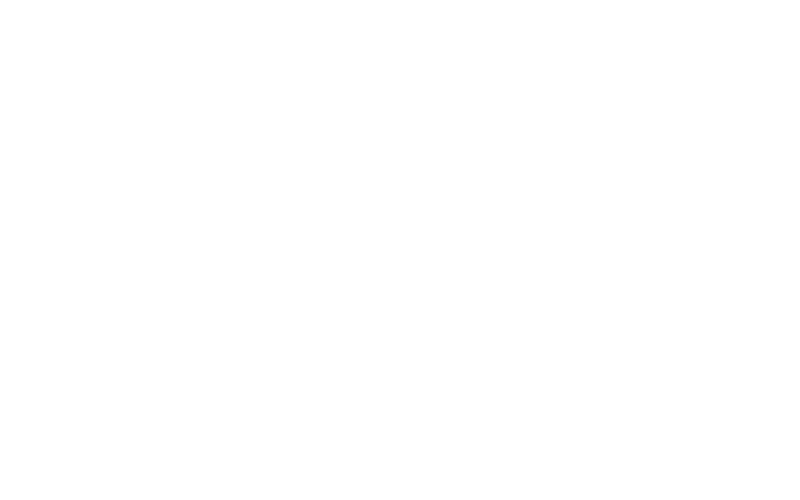

In [8]:
f, ax = plt.subplots(figsize=(8, 5))
ax.imshow(dxn_m.T, aspect='auto', origin='lower', 
          vmin=np.percentile(dxn_m.T, 10), 
          vmax=np.percentile(dxn_m.T, 95))

In [9]:
## SK = <STFT>**4 / <STFT**2>**2 - 2.

# Get the Short Time Fourier Transform of each subband (just 3 for now)
dt = dxn_sub[:, [36, 50]]

#from scipy.signal
sft = stft(dt, window='hamming', axis=0, nperseg=564, nfft=2048)

In [10]:
freqs[[36, 50]]

<Quantity [21.875   , 24.609375] MHz>

In [11]:
sk = spectral_kurtosis(sft[2], size=2) #size=1 if its just one subband, size=2 for multiple subbands at once

In [12]:
sft[2].shape

(1025, 2, 25974)

In [13]:
sk.shape

(1025, 2)

<IPython.core.display.Javascript object>


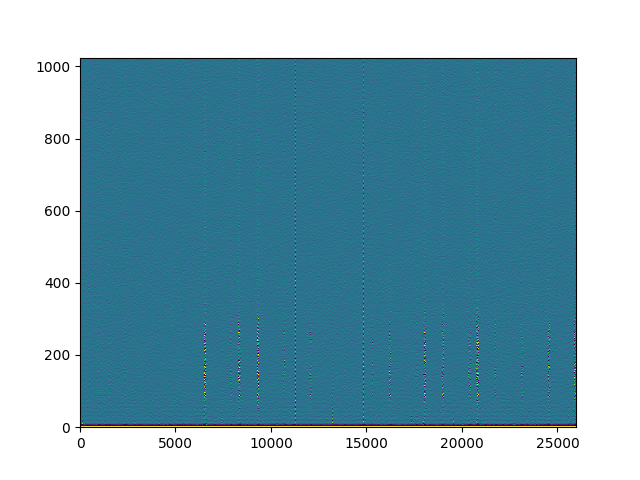

In [15]:
f, ax = plt.subplots()
plt.imshow(sft[2][:,0,:].real, aspect='auto', origin='lower', 
          vmin=np.percentile(sft[2].real, 15), 
          vmax=np.percentile(sft[2].real, 95))

In [16]:
sft[2].real.min()

-3.43337592926992

In [17]:
limit = sk_threshold(0.95, sft[2].shape[0])

In [18]:
limit

0.1224379794527208

(1025, 2, 25974)

In [19]:
sft_m = np.ma.masked_outside(sft[2], v1=-limit, v2=limit, copy=False)

In [25]:
sft_m[:,1,:]

masked_array(
  data=[[--, --, --, ..., --, --, (0.09216616894020126+0j)],
        [--, --, --, ..., --, --,
         (0.089392219439966-0.020705888478330232j)],
        [--, --, --, ..., --, (0.03905877553670197-0.8989942859215972j),
         (0.08130167744323678-0.039857432426324474j)],
        ...,
        [(0.0013055978409743253+0.0037251250565687216j),
         (0.0006040298039128627-0.0008325197733140332j),
         (0.0027281978706398522-0.01649252550072425j), ...,
         (0.0032572754190525292-0.002106049560848079j),
         (-0.006530851679459668+0.00666194258602082j),
         (0.002483507247622663+0.0014366515889738106j)],
        [(0.002599671709460744+0.001436907349374291j),
         (-0.0012091711739105494-0.002217635202269195j),
         (-0.011421398068185479-0.013519234938561326j), ...,
         (-0.0008937900939612838-0.003338411839105336j),
         (0.0030745772128346668+0.007910645518205466j),
         (0.0028157175911396348+0.0007543677379420495j)],
        [(0

<IPython.core.display.Javascript object>


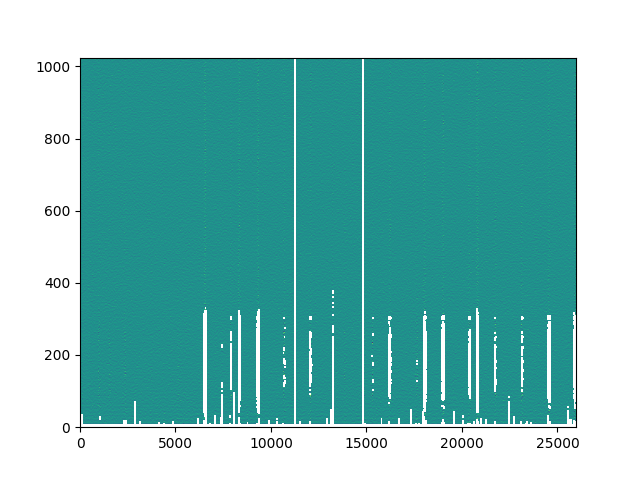

In [20]:
f, ax = plt.subplots()
plt.imshow(sft_m[:,0,:].real, aspect='auto', origin='lower', 
          vmin=np.percentile(sft_m.real, 5), 
          vmax=np.percentile(sft_m.real, 95))

<IPython.core.display.Javascript object>


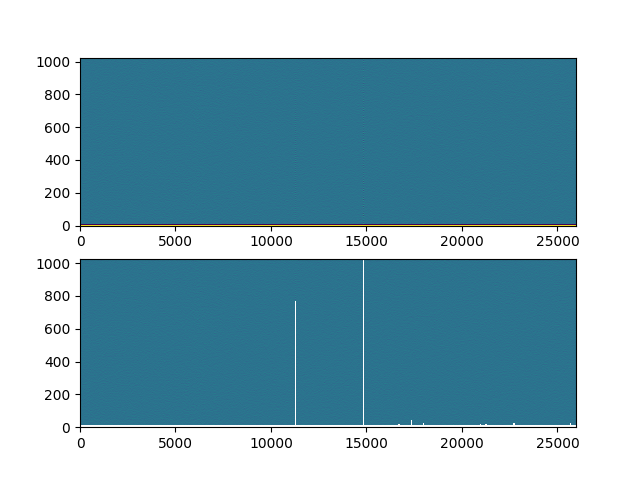

In [26]:
f, ax = plt.subplots(nrows=2)
ax[0].imshow(sft[2][:,1,:].real, aspect='auto', origin='lower', 
          vmin=np.percentile(sft[2].real, 15), 
          vmax=np.percentile(sft[2].real, 95))
ax[1].imshow(sft_m[:,1,:].real, aspect='auto', origin='lower', 
          vmin=np.percentile(sft[2].real, 15), 
          vmax=np.percentile(sft[2].real, 95))

In [27]:
dxn.shape

(7324219, 244)

In [ ]:
# do stft for whole spectrum
sft = stft(dxn, window='hamming', axis=0, nperseg=512, nfft=2048)

In [29]:
sft_m.shape

(1025, 2, 25974)

In [31]:
clean = []
for i in range(sft_m.shape[1]):
    subband_data_cleaned = istft(sft_m[:,i,:], window='hamming', nperseg=512, nfft=2048)
    clean.append(subband_data_cleaned)

In [51]:
len(clean[0][1])

6649088

In [52]:
dxn.shape[0] - 6649088

675131

In [57]:
clean[0][1].shape[0]

6649088

<IPython.core.display.Javascript object>


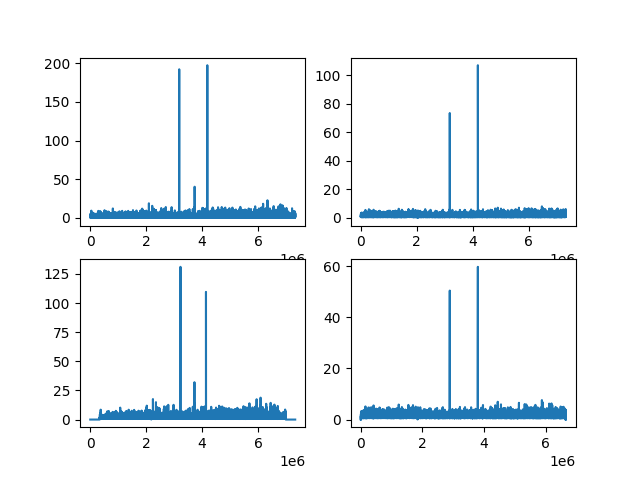

In [74]:
f, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].plot(dt[:,0])
ax[1,0].plot(padded_cleaned)
ax[0,1].plot(dt[:,1])
ax[1,1].plot(clean[1][1])

In [58]:
diff_len = dxn.shape[0] - clean[0][1].shape[0]

In [71]:
padded_cleaned = np.pad(clean[0][1], (int(diff_len/2), int(diff_len/2)+1), mode='linear_ramp', end_values=0)

In [72]:
padded_cleaned.shape

(7324219,)

In [73]:
dt[:,0].shape

(7324219,)

In [79]:
import dask.array as da
from dask.distributed import Client, progress

In [80]:
client = Client(threads_per_worker=4,
                n_workers=64, memory_limit='2GB')
client 

Client Scheduler: tcp://127.0.0.1:43495 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 256 Memory: 128.00 GB


In [78]:
dxn_m.shape

(7324219, 90)

In [85]:
dask_spectra = [da.from_array(dset, chunks=(100000,)) for dset in dxn_m]

In [87]:
dask_spectra.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
data = da.stack(dask_spectra, axis=0)

In [84]:
sft = stft(data_da, window='hamming', axis=0, nperseg=564, nfft=2048).compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ('array-original-5f590008aa1cde99c4b4e262bf2dcd11', <Worker 'tcp://127.0.0.1:34793', name: 13, memory: 0, processing: 1>)

In [ ]:
limit = sk_threshold(0.95, sft[2].shape[0])